In [ ]:
# !pip install colab-xterm
# %load_ext colabxterm
# %xterm
import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("default", category=RuntimeWarning)

!cat /proc/cpuinfo # see cpu info
!cat /proc/meminfo # see memory info

# A minimal model 

A system consisting of variables $(x_1, x_2, \cdots, x_N, z)$, where $x_i$'s are prey and $z$ is the predator ($2D$ coordinates as function of time).  The parameters are $N$, $a$, $b$, $c$, and $p$.

Taken from the paper, the prey dynamics is described by the following equation

$$
\frac{dx_j}{dt} = \frac{1}{N} \sum_{k=1,k\neq j}^{N} \left(\frac{x_j-x_k}{|x_j-x_k|^2}-a(x_j-x_k)\right) + b \frac{x_j-z}{|x_j-z|^2}
$$  

For the predator, it is  

$$
\frac{dz}{dt} = \frac{c}{N} \sum_{k=1}^{N} \frac{x_k-z}{|x_k-z|^p}
$$  

The system below has $2(N+1)$ variables

In [ ]:
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
from scipy.integrate import odeint  
from tqdm import tqdm

1.21.6


In [ ]:
def ringInit(N, seed = 0):  
  '''Initializes prey in a ring.'''  
  np.random.seed(seed)
  unit_interval = np.arange(0, 1, 1e-4)
  angles = 2 * np.pi * np.random.choice(unit_interval, size = N, replace = False)  
  R = np.random.uniform(0.25, 0.5, size = N)
  xprey = np.cos(angles) * R + 0.5
  yprey = np.sin(angles) * R + 0.5
  xpred = 0.5
  ypred = 0.5
  c0 = np.vstack((np.vstack((xprey, yprey)).T, [xpred, ypred]))
  return c0  

def randInit(N, seed = 0):
  '''Initializes prey randomly.'''  
  np.random.seed(seed)
  unit_interval = np.arange(0, 1, 1e-4) # values of x,y coordinates
  init = np.random.choice(unit_interval, size = 2*N+2, replace = False)
  xprey = init[0:N]  
  yprey = init[N+1:-1]
  xpred = init[N]
  ypred = init[-1]
  c0 = np.vstack((np.vstack((xprey, yprey)).T, [xpred, ypred]))
  return c0  

def multiPlot(case):
  '''
  Plots diagram given sampling times.  
  
  Parameters:
    - case: a tuple containing the following
      - soln: ndarray, solution  
      - h: time step size
      - sample_points: list, times to plot
      - size: int, fig size
  '''  
  soln, h, sample_points, size = case
  n = len(sample_points)
  plt.figure(figsize=(size, size))
  for j in range(n):  
    s = int(np.sqrt(n))+1
    ax = plt.subplot(s, s, j + 1)  
    i = int(sample_points[j] / h)
    i = i-1 if i>0 else 0
    plt.scatter(soln[i][0:N, 0], soln[i][0:N, 1])
    plt.scatter(soln[i][-1, 0], soln[i][-1, 1])
    # plt.xlim([-2,2])
    # plt.ylim([-2,2])
    plt.title(f'Time {sample_points[j]}')

## The 1st implementation

In [ ]:
import numpy as np  

def all(prey, pred, a, b, c, p):
    """
    Return an array, containing the velocity of
    the prey and the predator

    Input:
        pprey: (N, 2) numpy arr of (x,y) coordinates for the prey
        ppred: (1 , 2) numpy arr of (x,y) coordinates for the predator
        a, b, c, p: parameters

    Output:   
        vel_all: a size (N+1,2) numpy matrix of the velocity of prey and predator
    """   
    all = np.concatenate((prey, pred))
    #coordinates of prey and predator (all)

    N = all.shape[0] #Number of prey and predator
    #This N is N + 1 actually because it's # of prey + 1 predator
    
    dist_all = [all[i] - np.delete(all, i, axis = 0) for i in range(N)] 
    #Distance between all (There are repetitions in calculations) 
    #dist_all[i]: x_i - ~, dist_all[i][-1]: x_i - z
    
    normsq_all = [np.linalg.norm(dist_all[i], axis = 1)**2 for i in range(N)]
    #normsq_all = [np.linalg.norm(dist_all[i], axis = 1)**2  for i in range(N)]
    #Norm squared of all

    firstfac = [np.sum(dist_all[i][:-1] / normsq_all[i][:-1][:,None] - a* dist_all[i][:-1], axis = 0) for i in range(N - 1)]
    #firstfac = [np.sum(dist_all[i][:-1] / normsq_all[i][:-1][:,None], axis = 0) for i in range(N - 1)]

    #first2fac = [np.sum(a* dist_all[i][:-1], axis = 0) for i in range(N - 1)]


    secfac = [dist_all[i][-1] / normsq_all[i][-1] for i in range(N - 1)]
    
    vel_prey = np.matrix(firstfac)/ (N - 2) + b* np.matrix(secfac)

    #vel_prey = np.matrix([x - y for x,y in zip(firstfac, first2fac)])/ (N - 1) - b* np.matrix(secfac)
    
    res = normsq_all[-1]**(p/2)

    #res = [np.abs(dist_all[i])**p for i in range(N)]

    vel_pred = c * np.sum(-dist_all[-1] / res[:,None], axis = 0) / (N - 1)
    vel_pred = np.matrix(vel_pred) 
    
    vel_all = np.concatenate((vel_prey, vel_pred)) 

    return vel_all

## The 2nd implementation

## Forward Euler implementation 

Forward Euler gives:
$$
\begin{align*}
𝐮_1 &= c \\
𝐮_{k+1} &= 𝐮_{k} + hf(t_k, u_k)
\end{align*}
$$  

where $\mathcal{c}$ is the initial condition.  

For the 1st implementation

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt


def feuler1(f, c0, h, times, params, verbose = True):
  '''
  Implements forward euler.  

  Parameters:
    - f: function(time, u), the RHS of the DE, returning (dim, 2) ndarray of derivatives
    - c: ndarray of shape (dim, 2), initial condition 
    - h: float, time-step size
    - times: tuple, (start, end)
    - params: parameters
    - verbose: bool, indicates whether to print progress (for tracking)
  Returns:
    - y: ndarray of values computed at given times
  '''  

  start, end = times  
  t_span = np.arange(start, end, h)
  N, a, b, c, p = params

  # length of time
  t_len = len(t_span)
  print(f"No. of time steps: {t_len}")
  # initialize array to store values time x dimension x 2
  y = np.zeros((t_len, N+1, 2))

  y[0] = c0  
  # a list storing the derivatives for debugging
  grads = [] 

  for i in tqdm(range(t_len-1)):
    grad = f(y[i][0:N], y[i][-1:], a, b, c, p)
    grads.append(grad)
    y[i+1] = y[i] + h * grad
    if verbose and i%100 == 0:
      print(f"Iteration no. {i}")
  # if derivatives become constant
  # if verbose:
  #   for j in range(t_len-2):
  #     if (grads[j] == grads[j+1]).all():
  #       print(j)
  #       break
  return y  

To replicate the result in the paper, take the following set of parameters  

$$
\begin{aligned}
    N&=400 \\
    a&=1 \\
    b&=0.2 \\
    p&=3 \\
\end{aligned}
$$  
with $c$ ranging over the values $\{ 0.15, 0.4, 0.8, 1.5, 2.5\}$.  

The prey position are randomly initialized with in the ring $\{(x,y)| \frac{1}{2} \leq x^2 + y^2 \leq 1 \}$ and the predator is positioned at the origin.  (for $c=0.4$, we place all agents at random distinct positions in the unit square).

The parameters (using 400 prey)

In [ ]:
np.random.seed(0)

# step size
h = 0.02
N = 400
a = 1
b = 0.2
c = 1.5
p = 3  

Ring-like initialization for $c=1.5$

In [ ]:
c0 = ringInit(N)

Plot to see the initial distribution

In [ ]:
# initial plot
plt.scatter(c0[0:N,0], c0[0:N,1])
plt.scatter(c0[-1,0], c0[-1,1])
plt.title(f'Time 0')

In [ ]:
soln1 = feuler1(all, c0, h, (0, 20), (N, a, b, c, p), verbose = False)

In [ ]:
multiPlot(soln1, h, sample_points = [0,0.6,1.2,1.8,2.4,3,3.6], size = 12)

# Runge-Kutta Methods

Consider the problem of numerically approximating the solution to an $IVP$

$$
\frac{dy(t)}{dt} = f(y(t), t), \qquad y(t_0) = y_0
$$  

We estimate $y(t_0+h)$ from the derivatives and $y(t_0)$; we can continue this process to obtain the approximation at all time-steps.

## 2nd Order Runge-Kutta  

The steps are as follows:  

- Estimate derivative $k_1=f(y_0, t_0)$  

- Estimate function at $t_0 + \frac{h}{2}$ by $y(t_0+\frac{h}{2}) ≈ y(t_0)+\frac{h}{2} k_1$   

- Estimate derivative $k_2=f(y(t_0+\frac{h}{2}), t_0+\frac{h}{2})$  

- Estimate function at  $t_0 + h$, $y(t_0+h) ≈ y(t_0)+h k_2$

In [ ]:
'''Implements second order runge-kutta.'''  

def rk2(f, y0, h, times, params):
  '''
  Implements 2nd order Runge-Kutta.  

  Parameters:
  - f: function(time, u), the RHS of the DE, returning (dim, 2) ndarray of derivatives
  - y0: ndarray of shape (dim, 2), initial condition 
  - h: float, time-step size
  - times: tuple, (start, end)
  - params: parameters
  - verbose: bool, indicates whether to print progress (for tracking)
  Returns:
  - y: ndarray of values computed at given times
  '''  
  start, end = times  
  t_span = np.arange(start, end, h)
  N, a, b, c, p = params

  # length of time
  t_len = len(t_span)
  print(f"No. of time steps: {t_len}")
  # initialize array to store values time x dimension x 2
  y = np.zeros((t_len, N+1, 2))

  y[0] = y0  

  for i in tqdm(range(t_len-1)):
    k1 = np.array(f(y[i][0:N], y[i][-1:], a, b, c, p))
    y1 = y[i] + (h/2) * k1
    k2 = f(y1[0:N], y1[-1:], a, b, c, p)
    y[i+1] = y[i] + h * k2
    
  return y

## 4th Order Runge-Kutta  

The steps are as follows:  

- Estimate derivative $k_1=f(y_0, t_0)$   

- Estimate derivative $k_2=f(y(t_0)+k_1 \frac{h}{2}, t_0+\frac{h}{2})$  

- Estimate derivative $k_3=f(y(t_0)+ k_2 \frac{h}{2}, t_0+\frac{h}{2})$  

- Estimate function at  $t_0 + h$, $y(t_0+h) ≈ y(t_0)+k_3 h$

In [ ]:
'''Implements fourth order runge-kutta.'''  

def rk4(f, y0, h, times, params):
  '''
  Implements 4th order Runge-Kutta.  

  Parameters:
  - f: function(time, u), the RHS of the DE, returning (dim, 2) ndarray of derivatives
  - y0: ndarray of shape (dim, 2), initial condition 
  - h: float, time-step size
  - times: tuple, (start, end)
  - params: parameters
  - verbose: bool, indicates whether to print progress (for tracking)
  Returns:
  - y: ndarray of values computed at given times
  '''  
  start, end = times  
  t_span = np.arange(start, end, h)
  N, a, b, c, p = params

  # length of time
  t_len = len(t_span)
  print(f"No. of time steps: {t_len}")
  # initialize array to store values time x dimension x 2
  y = np.zeros((t_len, N+1, 2))

  y[0] = y0   
  
  for i in tqdm(range(t_len-1)):
    k1 = np.array(f(y[i][0:N], y[i][-1:], a, b, c, p))
    y1 = y[i] + (h/2) * k1
    k2 = np.array(f(y1[0:N], y1[-1:], a, b, c, p))
    y2 = y[i] + (h/2) * k2
    k3 = np.array(f(y2[0:N], y2[-1:], a, b, c, p))
    y[i+1] = y[i] + h * k3
    
  return y

## Reproducing the results

In [ ]:
'''Uses first implementation to obtain results.'''  

# getting rid of boilerplate  

def computeSoln(func, c, steps, times, 
                init_sty = 'ring', method = "rk4", 
                N = 400, a = 1, b = 0.2, p = 3,
                sample_points = [0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6], 
                size = 12):
  '''
  Computes solution and plots the graph.  

  Parameters:
    - func: function(time, u), the RHS of the DE, returning (dim, 2) ndarray of derivatives
    - c: c is parameter 
    - steps: int, no. of time steps
    - times: tuple, (start, end)
    - init_sty: string, initialization style, can be 'random' or 'ring'
    - method: string, solver to use, can be 'feuler', 'rk2', or 'rk4'
    - other parameters  
    - sample_points: points at which graph is drawn  
    - size: 
  Returns:
    - y: ndarray, solution
  '''  
  dim = N+1
  start, end = times  
  h = (end - start) / steps

  if init_sty == 'random':
    c0 = randInit(N)
  elif init_sty == 'ring':
    c0 = ringInit(N)  

  params = (N, a, b, c, p)  

  if method == 'rk4':  
    y = rk4(all, c0, h, times, params)
  elif method == 'rk2':
    y = rk2(all, c0, h, times, params)
  elif method == 'feuler':
    y = feuler1(all, c0, h, times, params, verbose = False)
  return (y, h, sample_points, size) 

### CASE 1  

- $c=0.15$
- $t=(0,100)$
- Sampled at $[0,45,55,60,70, 80, 100]$  

In [ ]:
case1 = computeSoln(all, 0.15, 1000, (0, 100), init_sty = 'ring', method = 'rk4', 
            sample_points = [0, 45, 55, 60, 70, 80, 100], size = 12)

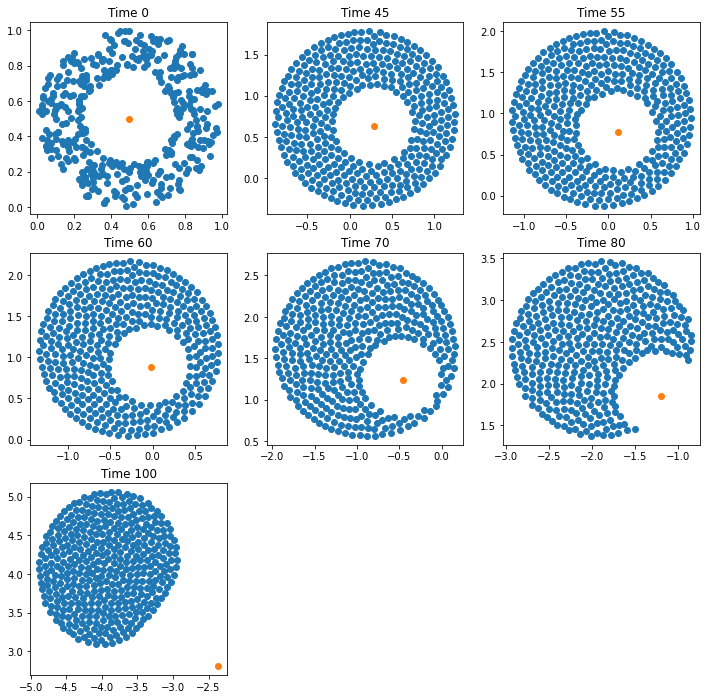

In [ ]:
multiPlot(case1)

### CASE 2  

- $c=0.4$
- $t=(0,22)$
- Sampled at $[0,0.35,0.85,2.35,4.85, 9.85, 21.05]$  

In [ ]:
case2 = computeSoln(all, 0.4, 1000, (0, 22), init_sty = 'random', method = 'rk4', 
            sample_points = [0, 0.35, 0.85, 2.35, 4.85, 9.85, 21.05], size = 12)  

No. of time steps: 1001


100%|██████████| 1000/1000 [01:18<00:00, 12.80it/s]


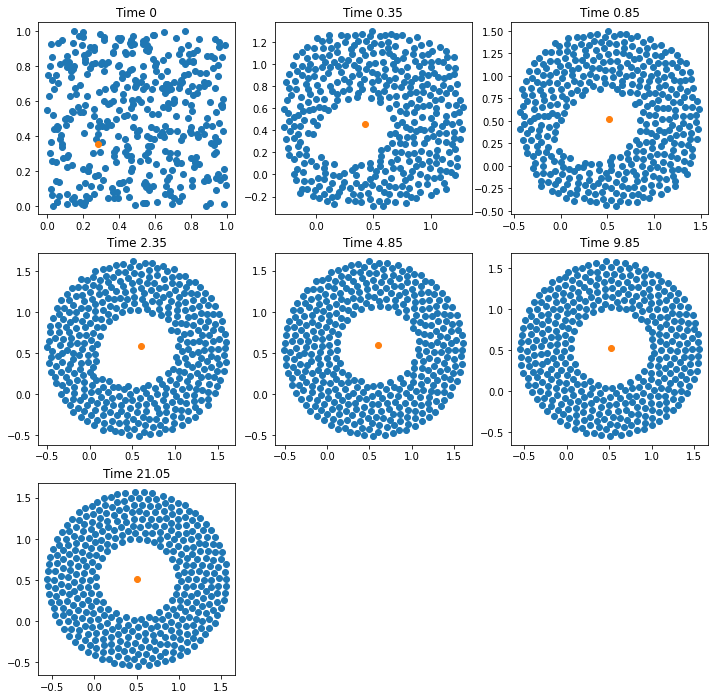

In [ ]:
multiPlot(case2)

### CASE 3 

- $c=0.8$
- $t=(0,140)$
- Sampled at $[0,4,123.8,125.8,127.8, 129.9, 131.8]$  

In [ ]:
case3 = computeSoln(all, 0.8, 1000, (0, 140), init_sty = 'ring', method = 'rk4', 
            sample_points = [0, 4, 123.8, 125.8, 127.8, 129.9, 131.8], size = 12)  

No. of time steps: 1000


100%|██████████| 999/999 [01:07<00:00, 14.83it/s]


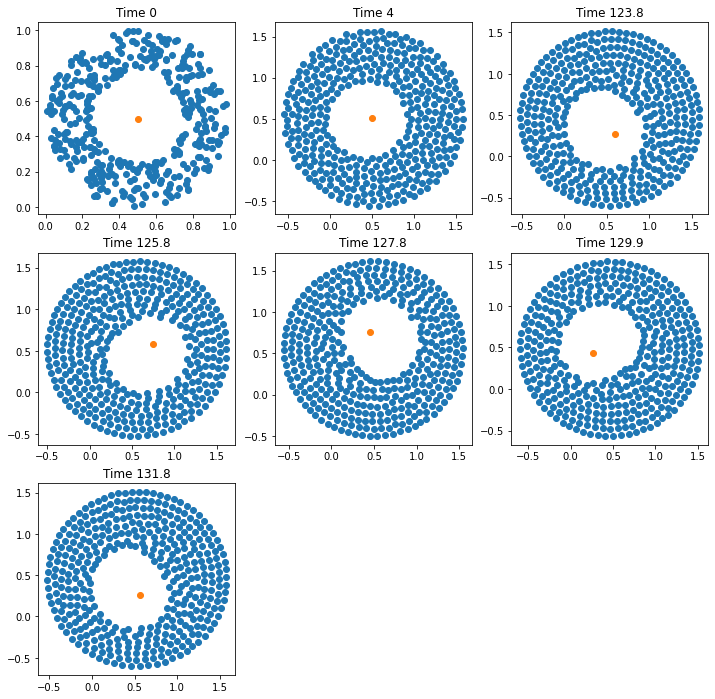

In [ ]:
multiPlot(case3)

### CASE 4  

- $c=1.5$
- $t=(0,4)$
- Sampled at $[0,0.6,1.2,1.8,2.4,3,3.6]$  



In [ ]:
case4 = computeSoln(all, 1.5, 1000, (0, 4), init_sty = 'ring', method = 'rk2', 
            sample_points = [0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6], size = 12)  


No. of time steps: 1000


100%|██████████| 999/999 [00:43<00:00, 22.79it/s]


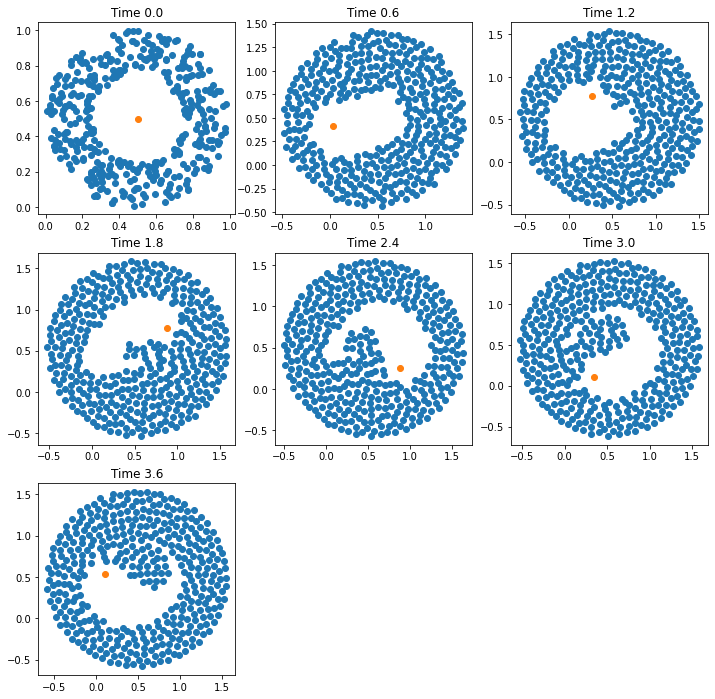

In [ ]:
multiPlot(case4)

### CASE 5  

- $c=2.5$
- $t=(0,2)$
- Sampled at $[0,0.2,0.4,0.6,0.8,1, 1.2]$  

In [ ]:
case5 = computeSoln(all, 2.5, 1000, (0, 2), init_sty = 'ring', method = 'feuler', 
            sample_points = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], size = 12)  

No. of time steps: 1000


100%|██████████| 999/999 [00:22<00:00, 45.41it/s]


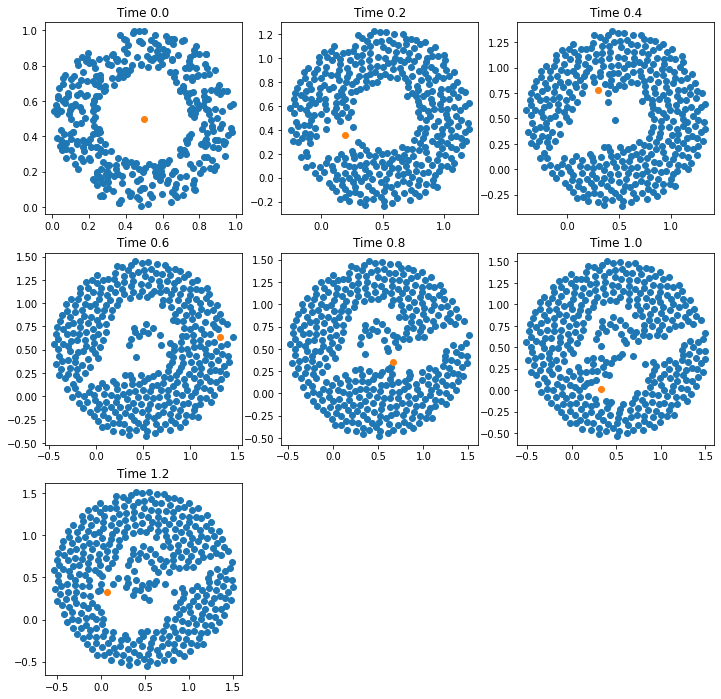

In [ ]:
multiPlot(case5)